# Table of Contents
* [Intro](#Intro)
	* [Autoencoder](#Autoencoder)
* [Numbers Encoding (Keras)](#Numbers-Encoding-%28Keras%29)
* [MNIST (Keras)](#MNIST-%28Keras%29)
* [Variational Autoencoders](#Variational-Autoencoders)
	* [Encoder](#Encoder)
	* [Decoder](#Decoder)


# Intro

Exploratory notebook related to Autoencoders. Includes toy examples implementation and testing of related techniques or subjects.

### Resources

[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [46]:
# Basic libraries import
import time
import numpy as np
import pdb
import sys
import os
from pathlib import Path
import seaborn as sns

# Keras
from keras.models import *
from keras.layers import *
from keras.layers.core import Activation, Dense
from keras import backend as K
from keras import optimizers
from keras.datasets import mnist
from keras import objectives
from keras.initializers import *
from keras.callbacks import *
from keras.utils.generic_utils import Progbar

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

sns.set_style("dark")
sns.set_context("paper")

%matplotlib notebook

# Local utils
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from utils.plot_utils import plot_sample_imgs
from utils import image_processing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Autoencoder

The goal of an autoencoder is to **learn a compressed and distributed representation of a dataset**. In the most general case it is then required for the autoencoder to be able to reconstruct the original input as accurately as possible (**minimize reconstruction error**). This technique **implicitly operates features extraction** and learning, which generally would outperform handcrafted features results.

For a single-layer feedforward net this can be achieved by using an hidden size smaller than the input one, and training on a function that consider how well the net is then able to reconstruct the input data. If hidden size is equal or higher than input size, the net should learn the identity matrix.

Additional concepts:
* sparsity and regularization
* Denoising Autoencoders (DAE):  where the training is between a corrupted version of the input and the correct one as output
* Variational Autoencoder

In [ ]:
data_folder = Path.home() / "Documents/datasets"

## Numbers Encoding (Keras)

An autoencoder that tries to learn a compressed (?binary) representation for one-hot encoded numbers.
    
1 = 00001  
2 = 00010  
3 = 00100  
4 = 01000  
5 = 10000

In [ ]:
# create one-hot encoded numbers
input_dim = 10
nums = np.eye(input_dim)[np.arange(input_dim)]
nums

In [ ]:
# model parameters
hidden_size = input_dim//2

# Keras model
model = Sequential()
model.add(Dense(hidden_size, input_dim=input_dim, activation=K.sigmoid))
model.add(Dense(input_dim, activation=K.sigmoid))
          
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit model
model.fit(nums, nums, epochs=100)

In [ ]:
model.summary()
layer_name = 'dense_2'

In [ ]:
# hidden layer weights
sns.heatmap(model.get_layer(layer_name).get_weights()[0])
sns.plt.show()

In [ ]:
# get hidden layer output building "intermediate model"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(nums)

In [ ]:
intermediate_output

In [ ]:
# predictions
sns.heatmap(model.predict(nums[np.array([1,2,3,5,6])]))
sns.plt.show()

## MNIST (Keras)

Train autoencoder on the MNIST dataset.

In [ ]:
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
# get only subset of images
num_images = 1000
X_train = X_train[:num_images].reshape(num_images, num_pixels).astype('float32')
X_test = X_test[:num_images].reshape(num_images, num_pixels).astype('float32')

In [ ]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
# Keras model
model = Sequential()
model.add(Dense(512, input_dim=num_pixels, activation=K.relu))
model.add(Dense(256, activation=K.relu))
model.add(Dense(512, activation=K.relu))
model.add(Dense(num_pixels, activation=K.relu))
          
# compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, X_train, batch_size=100, epochs=10)

In [ ]:
# show original test example
plt.imshow(X_test[5].reshape(28, 28), cmap='gray')

In [ ]:
# show predicted results
pred = model.predict(X_test[5].reshape(1, num_pixels))
plt.imshow(pred.reshape(28, 28), cmap='gray')

In [ ]:
# pick some original sample indexes
plot_side = 5
sample_indexes = np.random.choice(range(X_train.shape[0]), plot_side*plot_side)

In [ ]:
# show several original test examples
plot_sample_imgs(lambda _: X_test[sample_indexes], (28, 28), plot_side=plot_side)

In [ ]:
# show predicted results
plot_sample_imgs(lambda _: model.predict(X_test[sample_indexes]), (28, 28), plot_side=plot_side)

# [TODO] Denoising Autoencoder (DAE)

Improves on vanilla version by using a dataset where the training inputs have been corrupted with some sort of noise.

# Variational Autoencoder (VAE)

Just one constrain separates a normal autoencoder from a variational one: forcing "it to generate latent vectors that roughly follow a unit Gaussian distribution". The generation process is then about sampling a latent vector and feeding it to the decoder.

Resources:
* [VAE Explained](http://kvfrans.com/variational-autoencoders-explained/)
* [KL Loss with a unit gaussian](https://stats.stackexchange.com/questions/318184/kl-loss-with-a-unit-gaussian)

In [2]:
test_img_shape = (28, 28, 1)
test_latent_dim = 10

## Encoder

In [3]:
# standard convolution block used in the encoder
def encoder_conv_block(filters, block_input, kernel_size=(3, 3), strides=(1, 1)):
    block = Convolution2D(filters, kernel_size, strides=strides, padding='same')(block_input)
    block = LeakyReLU()(block)
    return block

In [4]:
# takes an image and generates two vectors: means and standards deviations
def encoder_model(input_shape, latent_dim, init_filters=64, num_conv_blocks=2):
    input_image = Input(shape=input_shape)
    
    x = input_image
    for i in range(num_conv_blocks):
        x = encoder_conv_block(init_filters*(2**i), block_input=x)

    features = Flatten()(x)
    
    # gaussian parameters
    mean_vector = Dense(latent_dim, activation='linear')(features)
    std_vector = Dense(latent_dim, activation='linear')(features)
    
    return Model(inputs=[input_image], outputs=[mean_vector, std_vector])

In [5]:
# instantiate test encoder
encoder = encoder_model(input_shape=test_img_shape, latent_dim=test_latent_dim, init_filters=64)
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  73856       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [6]:
# test encoder
encoder.predict(np.random.randint(0, 256, (1, *test_img_shape)))

[array([[  5.9118714 , -10.547602  ,   5.1338406 ,  -1.9291997 ,
          29.70231   ,   0.45835996, -22.48359   ,   6.2240562 ,
          -0.24060932,   0.9197411 ]], dtype=float32),
 array([[ -6.5296917, -28.025757 , -11.909079 ,  13.647819 ,  -5.473121 ,
         -18.757042 ,  49.873524 ,   6.2210164,  -5.2954063, -23.22677  ]],
       dtype=float32)]

## Decoder

In [7]:
# utility for the standard deconvolution block used in the decoder
def decoder_deconv_block(filters, block_input, kernel_size=(3, 3), strides=(1, 1)):
    block = UpSampling2D()(block_input)
    block = Convolution2D(filters, (3, 3), strides=strides, padding='same')(block)
    block = LeakyReLU()(block)
    block = BatchNormalization()(block)
    return block

In [8]:
# utility to get initial shape to get to final specified one
# based on the wanted number of deconv block. 
def get_initial_size(final_size, num_deconv_blocks, factor=2):
    if num_deconv_blocks==0:
        return final_size
    else:
        return get_initial_size(final_size//factor, 
                                num_deconv_blocks-1, 
                                factor=factor)

In [9]:
# takes as input the latent vector z
def decoder_model(latent_dim, img_shape, init_filters=128, num_deconv_blocks=2):
    latent_vector = Input([latent_dim])
    init_shape = tuple([get_initial_size(d, num_deconv_blocks) 
                        for d in img_shape[:-1]]+[init_filters])
    
    # CNN part
    x = Dense(1024)(latent_vector)
    x = LeakyReLU()(x)
    
    x = Dense(np.prod(init_shape))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Reshape(init_shape)(x)

    for i in range(num_deconv_blocks):
        x = decoder_deconv_block(init_filters // (1 if i == 0 else (2 ** i)), block_input=x)

    x = Convolution2D(img_shape[-1], (2, 2), padding='same', activation='sigmoid')(x)
    
    return Model(inputs=latent_vector, outputs=x)

In [10]:
# instantiate generate model
decoder = decoder_model(latent_dim=test_latent_dim, 
                        img_shape=test_img_shape,
                        init_filters=128,
                        num_deconv_blocks=2)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              11264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
__________

In [11]:
assert tuple(decoder.output.shape.as_list()[1:])==test_img_shape,\
      "Decoder output shape is different from input image shape"

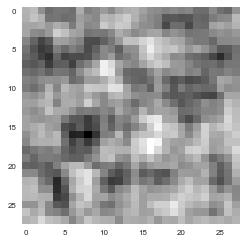

In [12]:
# plot random generated image
plt.imshow(decoder.predict([np.random.randn(1, test_latent_dim)])[0]
           .reshape(*test_img_shape[:-1]), cmap='gray')
plt.show()

## VAE Model

In [13]:
# sample latent vector using learned distribution parameters
def sampling(z_mean, z_log_sigma, batch_size, latent_dim):
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1.)
    # ?? use K.exp(z_log_sigma). Isn't our param is already z_sigma??
    return z_mean + z_log_sigma * epsilon

In [14]:
def get_vae_model(img_shape, latent_dim, init_filters=128, batch_size=32):
    # init model components
    encoder = encoder_model(input_shape=img_shape, latent_dim=latent_dim, init_filters=init_filters)
    decoder = decoder_model(latent_dim=latent_dim, img_shape=img_shape, init_filters=init_filters)
    
    # Build model
    input_img = Input(shape=(img_shape))
    mean_vector, std_vector = encoder(inputs=input_img)

    latent_vector = Lambda(lambda x : sampling(x[0], x[1], batch_size, 
                                               latent_dim))([mean_vector, std_vector])

    output_img = decoder(latent_vector)
    
    # Compile model
    
    # for the loss consider the sum of the generative loss
    # and the latent loss (KL divergence)
    def vae_loss(real_image, generated_image):
        gen_loss = K.mean(objectives.mean_squared_error(real_image, generated_image))
        kl_loss = - 0.5 * K.mean(1 + std_vector - K.square(mean_vector) - K.exp(std_vector), axis=-1)
        #kl_loss = 0.5 * K.mean(K.square(std_vector) + K.square(mean_vector) - K.log(K.square(std_vector)) -1, axis=-1)
        return gen_loss + kl_loss
    
    vae = Model(inputs=input_img, outputs=output_img)
    
    # TODO
    # Having/tracking separate loss functions which are then combined by Keras by given weights
    # in order for this to work you also need multiple outputs, one for each loss
    #gen_loss = Lambda(lambda real_image, generated_image : K.mean(objectives.mean_squared_error(real_image, generated_image)))
    #kl_loss = Lambda(lambda _1, _2 : - 0.5 * K.mean(1 + std_vector - K.square(mean_vector) - K.exp(std_vector), axis=-1))
    #vae.compile(loss=[gen_loss, kl_loss], loss_weights=[1., 1.], optimizer="adam")
    
    vae.compile(loss=vae_loss, optimizer="adam")
    
    return vae

## MNIST Train

In [15]:
img_shape = (28, 28, 1)
batch_size = 32
latent_dim = 10

In [21]:
# load mnist data using Keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape and normalize train data
nb_samples = 1024
X_train = X_train[:nb_samples]
y_train = y_train[:nb_samples]
#X_train = X_train[len(X_train)%batch_size:] # ??need divisible by batch size?
X_train = np.expand_dims(X_train, axis=-1)
X_train = X_train.astype('float32')/255
print(X_train.shape)
print(y_train.shape)

(1024, 28, 28, 1)
(1024,)


In [22]:
vae = get_vae_model(img_shape, latent_dim=latent_dim, init_filters=128, batch_size=batch_size)
decoder = vae.layers[3]
encoder = vae.layers[1]

In [23]:
epochs = 50

In [24]:
vae.fit(X_train, X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
1024/1024 [==============================] - 47s 46ms/step - loss: 0.1705
Epoch 2/50
1024/1024 [==============================] - 45s 44ms/step - loss: 0.0880
Epoch 3/50
1024/1024 [==============================] - 45s 44ms/step - loss: 0.0747
Epoch 4/50
1024/1024 [==============================] - 45s 44ms/step - loss: 0.0646
Epoch 5/50
1024/1024 [==============================] - 46s 45ms/step - loss: 0.0629
Epoch 6/50
1024/1024 [==============================] - 46s 45ms/step - loss: 0.0546
Epoch 7/50
1024/1024 [==============================] - 45s 44ms/step - loss: 0.0473
Epoch 8/50
1024/1024 [==============================] - 45s 44ms/step - loss: 0.0423
Epoch 9/50
1024/1024 [==============================] - 45s 44ms/step - loss: 0.0495
Epoch 10/50
1024/1024 [==============================] - 47s 46ms/step - loss: 0.0387
Epoch 11/50
1024/1024 [==============================] - 46s 45ms/step - loss: 0.0353
Epoch 12/50
1024/1024 [==============================] - 47s 46

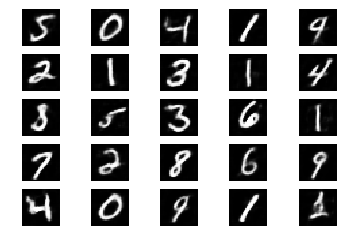

In [25]:
# plot VAE results
plot_sample_imgs(lambda x: vae.predict(X_train[:batch_size]), 
                 img_shape=img_shape[:-1],
                 plot_side=5)

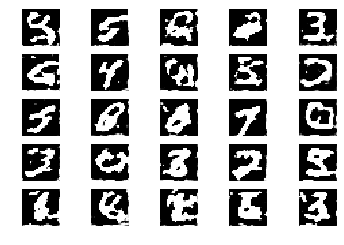

In [26]:
# plot decoder results
plot_sample_imgs(lambda x: decoder.predict([np.random.randn(32, 10)]), 
                 img_shape=img_shape[:-1],
                 plot_side=5)

## Explore Latent Space

In [27]:
# sample latent vector using learned distribution parameters
def numpy_sampling(z_mean, z_log_sigma, batch_size, latent_dim):
    epsilon = np.zeros(shape=(batch_size, latent_dim))
    #epsilon = np.random.normal(loc=0., scale=1., size=(batch_size, latent_dim))
    return z_mean + z_log_sigma * epsilon

In [28]:
# get latent vector for given target by feeding the target to the encoder
def get_z(target, latent_dim):
    z_mean, z_log_sigma = encoder.predict(target)
    z = numpy_sampling(z_mean, z_log_sigma, 1, latent_dim)
    return z

### Latent Space Interpolation
Animation of the continuous interpolation between two distinct examples.

In [29]:
# indexes of start and end entries in the training data
start_idx = 0
end_idx = 1

print("Start value: {}".format(y_train[start_idx]))
print("End value: {}".format(y_train[end_idx]))

Start value: 5
End value: 0


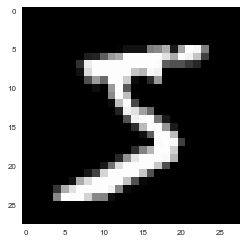

In [33]:
plt.imshow(X_train[start_idx].reshape(img_shape[:-1]), cmap='gray')
#plt.imshow(X_train[end_idx].reshape(img_shape[:-1]), cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


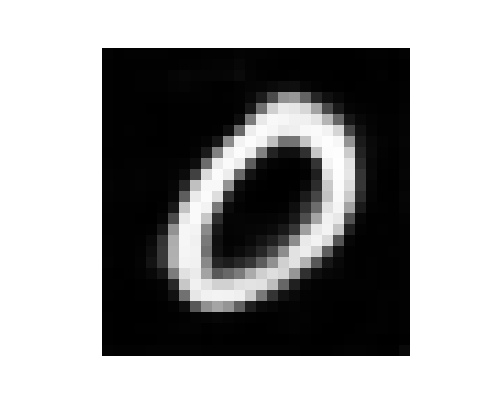

In [50]:
# Get latent vector for start and end, and compute diff
z_start = get_z(X_train[start_idx:start_idx+1], latent_dim)
z_end = get_z(X_train[end_idx:end_idx+1], latent_dim)
z_diff = z_end - z_start

# setup plot
nb_frames = 50
fig, ax = plt.subplots(dpi=100, figsize=(5, 4))
im = ax.imshow(X_train[start_idx].reshape(img_shape[:-1]), cmap='gray')
plt.axis('off')

def animate(i, z_start, z_diff, nb_frames):
    z_start += z_diff/nb_frames
    im.set_data(decoder.predict(z_start).reshape(img_shape[:-1]))

ani = animation.FuncAnimation(fig, animate, frames=nb_frames, interval=100, 
                              fargs=[z_start, z_diff, nb_frames])